# importation
***

In [52]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from cv2 import resize
import keras.layers
import keras.applications
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score
from IPython.display import clear_output
import seaborn as sns

# some functions
***

this is a function to load pics data which every one of them are in diff folders and outputs 2 lists, a pics and a labels.

In [3]:
def loading_from_directory(the_path: str , size: tuple[int , int] | int , random_state = 42 , shuffling = True) -> tuple[list , list]: 
    if type(size) is int:
        height = width = size
    else:
        height , width = size # size of pic
    pics = [] # where pics gonna be stored
    labels = [] # where labels gonna be stored
    categories_name = os.listdir(the_path)

    for category_name in categories_name:
        category_dir = os.path.join(the_path , category_name)
        files_dir = os.listdir(category_dir)

        for file in files_dir:
            file_path = os.path.join(category_dir , file)
            file = plt.imread(file_path)

            file = resize(file , dsize = (height , width))
            pics.append(file)
            labels.append(category_name)
    if shuffling:
        return shuffle(pics , labels , random_state = random_state)
    else:
        return pics , labels

this one takes a list and assign their unique index to everyone of them

In [23]:
def str_to_num_list(list):
    unique_list = np.unique(list) # finding all unique elements of our list
    for i in range(len(list)):
        string = list[i]
        num_to_assign, = np.where(unique_list == string) # we assign respective index of the element in unique_list to every element in our list
        list[i] = int(num_to_assign)


# loading data
***

In [60]:
X , y = loading_from_directory(the_path = r'D:\datasets\flowers\flowers' , size = 200)

In [61]:
unique_y = np.unique(y)

In [33]:
str_to_num_list(y)
clear_output()

In [35]:
X_train , X_test , y_train , y_test = train_test_split(np.array(X) , np.array(y) , test_size = 0.1 , random_state = 42)
X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.1 , random_state = 42)

using transfer learning

In [40]:
model = keras.applications.EfficientNetB2(input_shape = (200 , 200 , 3) , classes = 5 , include_top = False)
model.trainable = False
flatten = keras.layers.Flatten()(model.layers[-1].output)
dns1 = keras.layers.Dense(128 , activation = 'relu' , kernel_constraint = keras.constraints.max_norm(0.6))(flatten)
drop1 = keras.layers.Dropout(rate = 0)(dns1)
dns2 = keras.layers.Dense(64 , activation = 'relu' , kernel_constraint = keras.constraints.max_norm(0.6))(drop1)
drop2 = keras.layers.Dropout(rate = 0)(dns2)
dns3 = keras.layers.Dense(64 , activation = 'relu' , kernel_constraint = keras.constraints.max_norm(0.6))(drop2)
final = keras.layers.Dense(5 , activation = 'softmax')(dns3)

model = keras.Model(inputs = model.input , outputs = final)
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = keras.optimizers.Adam(learning_rate = 0.00005) , metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 200, 200, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 200, 200, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [41]:
history = model.fit(X_train , y_train , validation_data=(X_val , y_val) , batch_size = 32 , epochs = 12)

Epoch 1/12
110/110 [==============================] - 18s 115ms/step - loss: 0.5887 - accuracy: 0.8006 - val_loss: 0.3024 - val_accuracy: 0.8689
Epoch 2/12
110/110 [==============================] - 11s 101ms/step - loss: 0.1818 - accuracy: 0.9499 - val_loss: 0.2468 - val_accuracy: 0.9152
Epoch 3/12
110/110 [==============================] - 11s 102ms/step - loss: 0.0777 - accuracy: 0.9860 - val_loss: 0.2593 - val_accuracy: 0.9049
Epoch 4/12
110/110 [==============================] - 11s 101ms/step - loss: 0.0433 - accuracy: 0.9943 - val_loss: 0.2473 - val_accuracy: 0.9100
Epoch 5/12
110/110 [==============================] - 11s 101ms/step - loss: 0.0275 - accuracy: 0.9969 - val_loss: 0.2439 - val_accuracy: 0.9126
Epoch 6/12
110/110 [==============================] - 11s 102ms/step - loss: 0.0191 - accuracy: 0.9977 - val_loss: 0.2542 - val_accuracy: 0.9152
Epoch 7/12
110/110 [==============================] - 11s 102ms/step - loss: 0.0159 - accuracy: 0.9974 - val_loss: 0.2433 - val_ac

<Axes: >

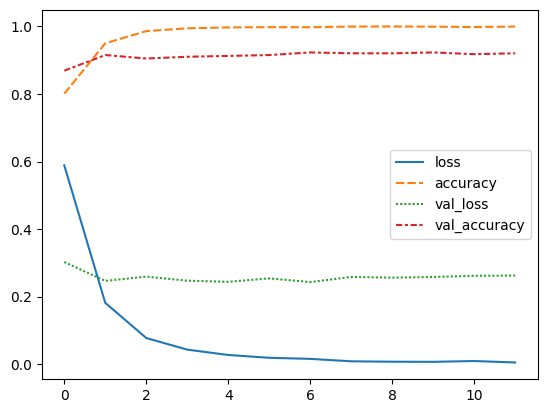

In [42]:
sns.lineplot(history.history)

In [ ]:
predictions = model.predict(X_test , verbose = False)

res = []
for p in predictions:
    res.append(np.nanargmax(p))

In [ ]:
acc = accuracy_score(y_true = y_test , y_pred = res)
f1 = f1_score(y_true = y_test , y_pred = res , average = 'micro')

print(f'accuracy score: {acc}')
print(f'f1 score: {f1}')

accuracy score: 0.9120370370370371
f1 score: 0.9120370370370371


<Axes: >

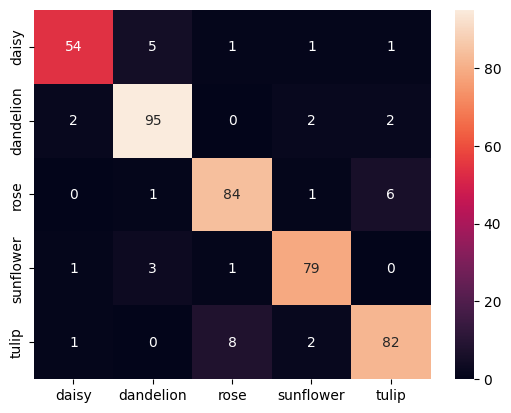

In [64]:
conf_mat = confusion_matrix(y_true = y_test , y_pred = res)
sns.heatmap(conf_mat , annot = True , xticklabels = unique_y , yticklabels = unique_y)

In [43]:
model.save('model.h5')

### thats a acceptable model